<a href="https://colab.research.google.com/github/marymuthee/obia_notebooks/blob/main/02_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we will explore some fundamental methods for extracting features. Specifically, we will use the term "**features**" to refer to the various attributes used to describe and classify segments in an image.

Once segments have been created in an image (as we did in the previous notebook), the next crucial step is to characterize these segments in a way that captures their meaningful properties. The strength of **Object-Based Image Analysis (OBIA)** lies in its ability to use various features to characterize segments, extending beyond simple spectral properties. Features such as shape, texture, and contextual characteristics can greatly enhance the classification of these segments.

Extracting features in Python requires aggregating pixel information for each segment. There are various ways to achieve this. In Python, the `regionprops()` function from the [skimage](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) library can be used as it comes with several pre-implemented features.

## **Setup**

Please run the cell below. After that, go to **Runtime -> Restart session**, and confirm. Once the session restarts, move on to the next cell **without running this one again**.

In [1]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    import os
    repo_dir = "obia_tutorials"
    marker_file = os.path.join(repo_dir, ".setup_done")

    # Setup the environment only if it hasn't been done already
    if not os.path.exists(marker_file):
        # Clone the repository
        !git clone https://github.com/mariarodriguezn/obia_tutorials.git

        # Install the required packages
        !pip install -r obia_tutorials/requirements.txt

        # Create a marker file to avoid re-running the setup
        with open(marker_file, 'w') as f:
            f.write("Setup completed")

In [2]:
# imports
import matplotlib.colors as mcolors  #plotting
import matplotlib.pyplot as plt #plotting
import numpy as np  #numeric data
import pandas as pd  #tabular data
import time
import rasterio  #for raster data manipulation

from matplotlib import rcParams #plotting
from scipy import stats #for statistical features
from skimage import graph  #merging neighbouring segments
from skimage.color import label2rgb #segments visualization
from skimage.measure import regionprops, regionprops_table  #computes proporties for each segment
from skimage.morphology import binary_dilation  #for boundaries and edges
from skimage.segmentation import mark_boundaries, slic #visualization
from skimage.util import map_array  #maps old values to new ones
from tqdm import tqdm


# set general figsize
rcParams['figure.figsize'] = (7.5, 7.5)

## **Exemplary data**

In this notebook, we will continue working with the same high-resolution image used in the first notebook of this series. This image contains four spectral bands: Red, Green, Blue, and Near-Infrared (NIR). Additionally, we will utilize the Normalized Difference Vegetation Index (NDVI) that was calculated from these bands.

Our analysis will begin with a segmentation process using the Simple Linear Iterative Clustering (SLIC) algorithm, which was also introduced in the first notebook. Specifically, we will use a compactness value of 0.3 and set the number of superpixels to 3000. This segmentation will help us divide the image into manageable segments, which we will then characterize using various features.

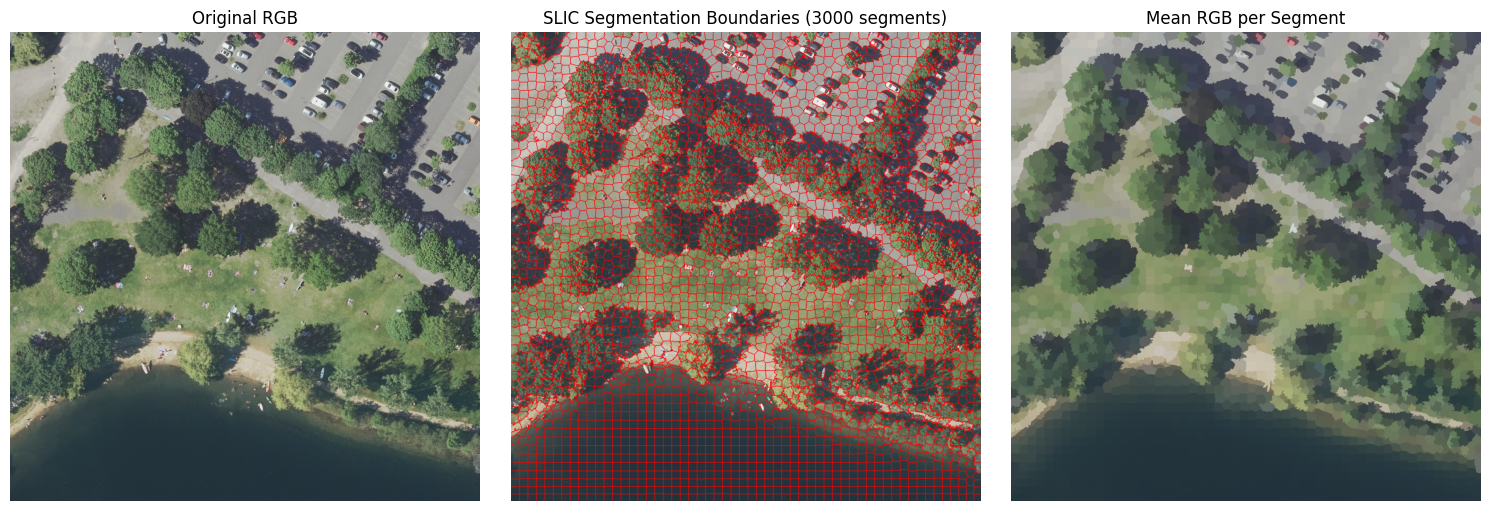

In [3]:
# File path to the image
img_path = "obia_tutorials/sample_data/ortho_subset_I.tif"

# Read the image and extract the bands
with rasterio.open(img_path) as src:
    # Extract red, green, blue, and NIR bands, normalize to [0, 1]
    bands = src.read([1, 2, 3, 4]).astype(float) / 255
    red, green, blue, nir = bands

# Stack RGB into an array
rgb = np.stack([red, green, blue], axis=-1)

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)  # small value added to avoid division by zero

# Stack all bands into an array
image = np.stack([red, green, blue, nir], axis=-1)

# Set the fixed compactness and number of superpixels
compactness = 0.3
n_segments = 3000

# Generate segments using SLIC
segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries ({n_segments} segments)")

# Display the mean RGB per segment
axs[2].imshow(label2rgb(segments, rgb, kind='avg'))
axs[2].set_title("Mean RGB per Segment")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()

From executing the next two cells, we can observe two key points:

1.   **Image Details**: The image has a resolution of 1500x1500 pixels and contains four spectral bands: Red, Green, Blue, and Near-Infrared (NIR). This high resolution allows us to explore the scalability of the feature extractions. To facilitate this, a **decorator** will be used to measure the execution time of certain functions defined later on.

2.    **Segmentation Results**: The resulting segments (2957) from the SLIC method are slightly fewer than the target number of superpixels (3000) selected. This is expected because the SLIC algorithm balances color similarity with spatial proximity, sometimes merging or adjusting segments to maintain coherence, especially in areas with less distinct boundaries. As a result, the final number of segments may be slightly lower than the requested number.


In [4]:
# Print basic information on image & segmentation
print(f"Image shape: {image.shape}")
print(f"Number of segments: {len(np.unique(segments))}")

Image shape: (1500, 1500, 4)
Number of segments: 2957


In [5]:
# Decorator for timing
def timeit(method):
    def timed(*args, **kw):
        tstart = time.perf_counter()
        result = method(*args, **kw)
        tend = time.perf_counter()
        total_ms = (tend - tstart)
        print(f"Execution time: {total_ms:.2f}s")
        return result
    return timed

## **Types of features**

### **I. Spectral features**

Spectral features capture the radiometric properties of segments by analyzing pixel values across different spectral bands. In this tutorial we've focused on the **intensity mean** and **standard deviation** spectral features.

#### **I. Intensity Mean**

 The intensity mean represents the average spectral value for each band within a segment. This value is crucial as it provides a summary statistic of the segment's radiometric properties, which can be used for further classification or analysis.

In the code below, by using the `regionprops_table` function from the [skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) module we compute the intensity mean values for each segment across the different bands (Red, Green, Blue, and NDVI).

In [9]:
# Define intensity mean calculation function
@timeit
def calc_mean(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr, # Segmented image
        intensity_image = img_arr, # Image stack (R, G, B, NDVI)
        properties = ["label", "intensity_mean"] # Calculate intensity mean per band
        )
    return pd.DataFrame(spec_feats)

# Perform calculation
means = calc_mean(segments, np.dstack([rgb, ndvi]))
display(means)

Execution time: 0.50s


label  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0         1          0.604319          0.625089          0.583083   
1         2          0.359322          0.392994          0.320563   
2         3          0.441907          0.489653          0.374884   
3         4          0.234354          0.266893          0.268920   
4         5          0.205337          0.234459          0.260040   
...     ...               ...               ...               ...   
2952   2953          0.140090          0.206220          0.241319   
2953   2954          0.141707          0.208822          0.243838   
2954   2955          0.143506          0.209567          0.246361   
2955   2956          0.144446          0.210656          0.247117   
2956   2957          0.147464          0.215750          0.250353   

      intensity_mean-3  
0             0.039661  
1             0.288713  
2             0.253889  
3             0.421836  
4             0.406761  
...                ...  
2952          0.222641  
2953          0.224049  
2954          0.217008  
2955          0.215110  
2956          0.207404  

[2957 rows x 5 columns]

Now, let's see how the mean NDVI is distributed within each segment. On the left, we have the original RGB image with the SLIC segment boundaries, and on the right, the mean NDVI values are displayed for each segment.

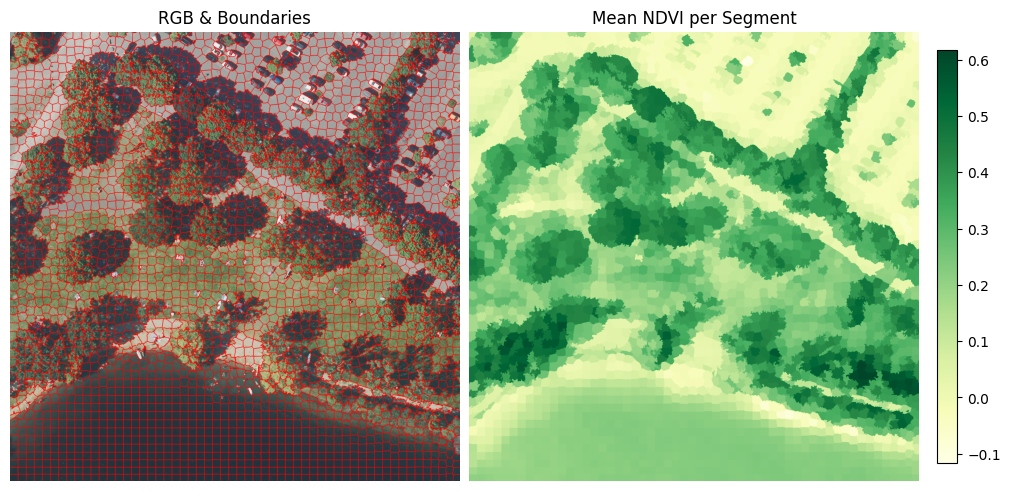

In [10]:
# Mapping NDVI mean values back to image segments
mapped_mean = map_array(
    segments,
    np.array(means["label"]),
    np.array(means["intensity_mean-3"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
im = axs[1].imshow(mapped_mean, cmap="YlGn")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("NDVI per Pixel")
axs[1].set_title("Mean NDVI per Segment")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()


#### **II. Standard Deviation**

Standard deviation is a statistical measure that tells how much the values within a segment vary from the mean. In the context of image analysis, calculating the standard deviation for each segment can provide insights into the homogeneity or variability of the segment's pixel values. For example, a low standard deviation in an NDVI segment might indicate uniform vegetation health, while a high standard deviation could suggest a mix of healthy and stressed vegetation within that segment.

To calculate the standard deviation for each segment, we can create a custom function using the `extra_property` parameter in `regionprops`. The function uses a `regionmask`, which identifies the pixels belonging to the segment and calculates their standard deviation.

The following example demonstrates how to use the `extra_property` parameter in regionprops to calculate the standard deviation of pixel values within each segment for the Red, Green, Blue, and NDVI bands.

In [8]:
# Define a custom function to calculate the standard deviation for each segment
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    std = np.std(vals)
    return std

@timeit

# Define a function to calculate standard deviation for all segments
def calc_std(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label",],
        extra_properties=(std,)
        )
    return pd.DataFrame(spec_feats)

# Perform calculation
stds = calc_std(segments, np.dstack([rgb, ndvi]))
display(stds)

Execution time: 1.03s


label     std-0     std-1     std-2     std-3
0         1  0.064737  0.062445  0.086558  0.071410
1         2  0.094232  0.107423  0.076962  0.068792
2         3  0.095153  0.102003  0.070536  0.065811
3         4  0.050760  0.054977  0.033114  0.059759
4         5  0.044260  0.065769  0.034007  0.043664
...     ...       ...       ...       ...       ...
2952   2953  0.007511  0.010727  0.011009  0.016770
2953   2954  0.007561  0.010474  0.010760  0.015958
2954   2955  0.006894  0.010396  0.010581  0.014103
2955   2956  0.008707  0.012481  0.013286  0.018723
2956   2957  0.007159  0.010982  0.012027  0.015294

[2957 rows x 5 columns]

Now, let's explore how the standard deviation of NDVI values is distributed within each segment. On the left, we have the original RGB image with the SLIC segment boundaries, and on the right, the standard deviation of NDVI values is displayed for each segment.

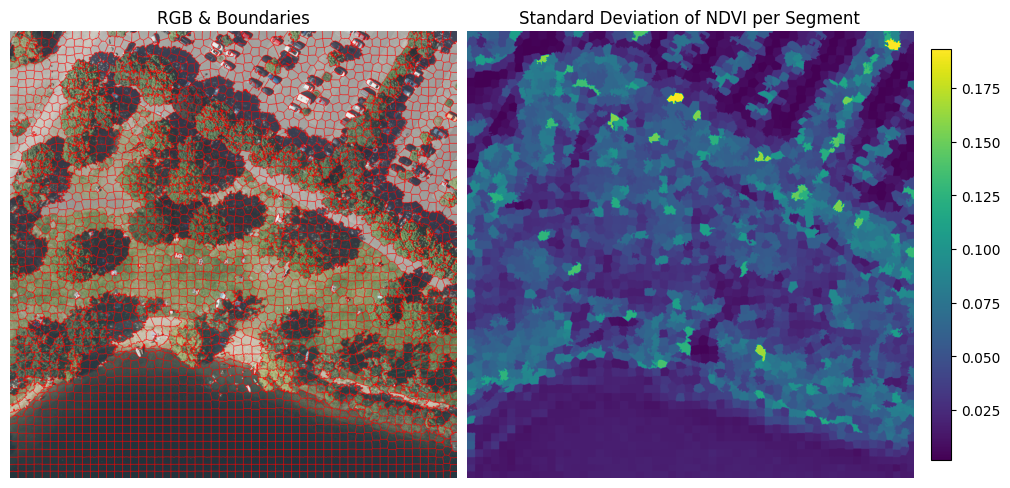

In [11]:
# Map the standard deviation of NDVI values back to image segments
mapped_std = map_array(
    segments,
    np.array(stds["label"]),
    np.array(stds["std-3"])
)

# Visualize the RGB image with segment boundaries and the standard deviation of NDVI
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

# Display the original RGB image with segment boundaries
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

# Display the standard deviation of NDVI per segment with the 'viridis' colormap
im = axs[1].imshow(mapped_std, cmap="viridis")
axs[1].set_title("Standard Deviation of NDVI per Segment")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Remove axis for both subplots
for ax in axs.flat:
    ax.set_axis_off()

# Show the plots
plt.show()


### **II. Shape features**

In addition to spectral features, **shape features** provide valuable information about the form and structure of segments, which can be critical in applications such as object recognition, land cover classification, and more.

Common shape features include **rectangularity**, **compactness**, and **solidity**, which we've focused on in this tutorial. Other useful shape features include elongation, which measures how stretched or elongated a segment is, and circularity, which assesses how close the shape of a segment is to a perfect circle.


#### **I. Rectangularity**

Rectangularity is a measure of how closely the shape of a segment approximates a rectangle. It is defined as the ratio between the segment's area and the area of its bounding box. A segment that perfectly fills its bounding box will have a rectangularity value of 1, while segments that are more irregularly shaped will have lower values.

Here’s how we can calculate rectangularity:

In [14]:
# Define a custom function to calculate the rectangularity of each segment
def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

@timeit
# Define a function to calculate rectangularity for all segments
def calc_rect_shapes(seg_arr):
    shp_feats = regionprops_table(
        label_image = seg_arr,
        properties = ["label", "area_bbox"],
        extra_properties=(rectangularity,)
        )
    return pd.DataFrame(shp_feats)

# Perform the rectangularity calculation for each segment and display the results
rects = calc_rect_shapes(segments)
display(rects)

Execution time: 0.30s


label  area_bbox  rectangularity
0         1     1026.0        0.500000
1         2      810.0        0.572840
2         3     1122.0        0.559715
3         4      999.0        0.884885
4         5     1131.0        0.801061
...     ...        ...             ...
2952   2953      621.0        1.000000
2953   2954      621.0        1.000000
2954   2955      598.0        0.996656
2955   2956      575.0        0.940870
2956   2957      506.0        0.976285

[2957 rows x 3 columns]

Now, let's explore how the rectangularity of segments is distributed across the image. On the left, we have the original RGB image with the segment boundaries clearly defined, and on the right, we will map and display the rectangularity values for each segment.

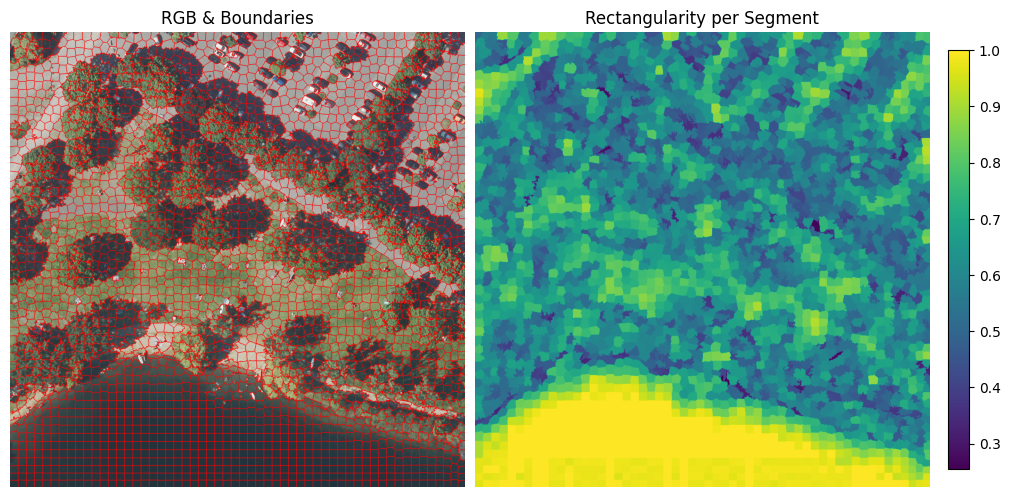

In [15]:
# Map rectangularity values back to the image segments
mapped_rectangularity = map_array(
    segments,
    np.array(rects["label"]),            # Segment labels
    np.array(rects["rectangularity"])    # Rectangularity values
)

# Visualize the RGB image with segment boundaries and rectangularity
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

# Display the original RGB image with segment boundaries
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

# Display the rectangularity per segment
im = axs[1].imshow(mapped_rectangularity, cmap="viridis")
axs[1].set_title("Rectangularity per Segment")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Remove axis for both subplots
for ax in axs.flat:
    ax.set_axis_off()

# Show the plots
plt.show()


It's important to note that **rectangularity**, as defined above, is not **rotation-invariant**. This means that the rectangularity value of a segment can change depending on its orientation. For instance, if a segment represents a parked car, the rectangularity will vary if the car is oriented differently, even though it's still the same object. Because natural objects often have various orientations, **rectangularity might not always be a reliable or meaningful feature for all applications**.

Other shape features, such as **compactness**, can provide more consistent and meaningful insights. These features relate the area of an object to its perimeter and are often more robust against changes in orientation.

#### **II. Compactness & Solidity**

*   **Compactness** quantifies how closely a segment's shape resembles a circle. High compactness indicates a circular shape, while lower values suggest more elongated or irregular shapes. This metric is useful for distinguishing between objects with similar areas but different shapes, such as circular ponds versus irregular river sections.

  It is calculated using the formula:

  \begin{equation}
  \text{Compactness} = \frac{4 \times \pi \times \text{Area}}{\text{Perimeter}^2}
  \end{equation}


*  **Solidity** measures how "solid" or "filled" a shape is by comparing the segment’s area to its convex hull (the smallest convex shape that can enclose the segment). High solidity suggests a solid shape with few indentations, while lower values indicate shapes with significant gaps or concavities.

  It is calculated using the formula:
  \begin{equation}
  \text{Solidity} = \frac{\text{Area of the Segment}}{\text{Area of the Convex Hull}}
  \end{equation}



In [16]:
# Define a function to calculate shape features, including compactness and solidity
@timeit
def calc_shapes(seg_arr, solidity=True):
    if solidity:
        props = ["label", "solidity", "area", "perimeter"]
    else:
        props = ["label", "area", "perimeter"]
    shp_feats = regionprops_table(
        label_image = seg_arr,
        properties = props,
        )
    compactness = 4*np.pi*shp_feats["area"]/(shp_feats["perimeter"]**2)
    shp_feats["compactness"] = compactness
    shp_feats.pop("area")
    shp_feats.pop("perimeter")
    return pd.DataFrame(shp_feats)

# Perform the shape calculations and display the results
shapes = calc_shapes(segments)
display(shapes)

Execution time: 3.07s


label  solidity  compactness
0         1  0.847934     0.491792
1         2  0.800000     0.341122
2         3  0.808237     0.386013
3         4  0.928571     0.627548
4         5  0.959746     0.741152
...     ...       ...          ...
2952   2953  1.000000     0.846757
2953   2954  1.000000     0.846757
2954   2955  0.998325     0.843259
2955   2956  0.969534     0.824069
2956   2957  0.988000     0.850896

[2957 rows x 3 columns]

Calculating the convex hull image for solidity can be computationally demanding (as evidenced in the cell below), especially when working with large datasets. Because of this, compactness is often a better choice when processing speed is important.

In [17]:
# Compare timing between Compactness and Solidity calculations
print("Solidity & Compactness")
_ = calc_shapes(segments)

print(f"\nCompactness")
_ = calc_shapes(segments, solidity=False)

Solidity & Compactness
Execution time: 3.99s

Compactness
Execution time: 0.57s


Let's check below how compactness and solidity values are distributed within each segment.

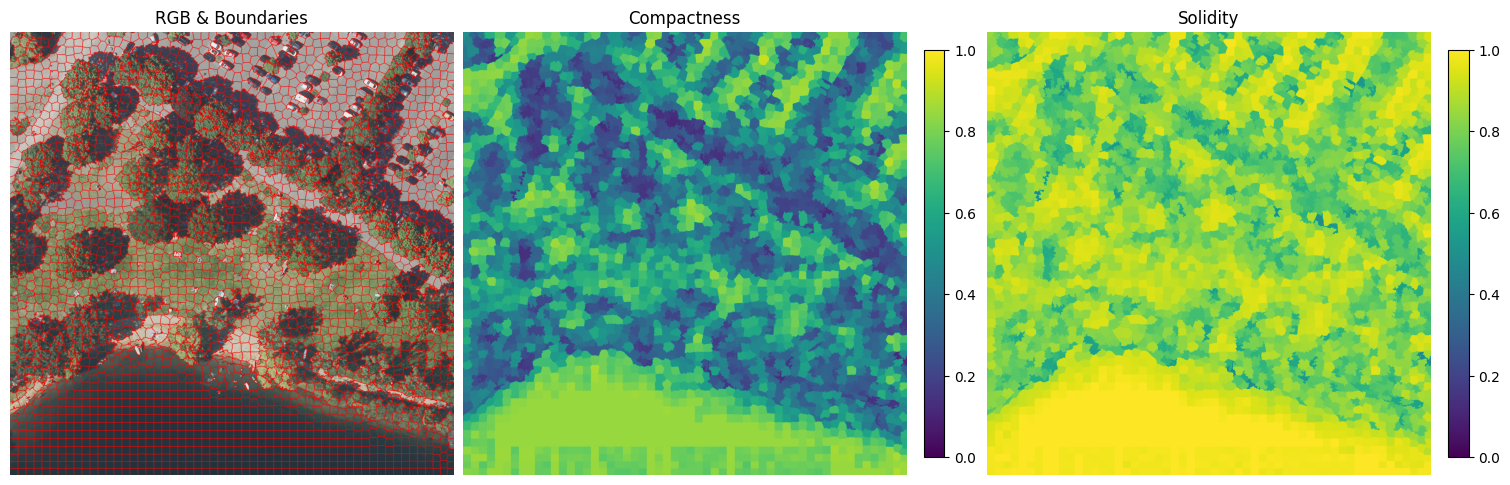

In [18]:
# Map compactness and solidity values back to their corresponding segments in the image
mapped_compactness = map_array(segments, np.array(shapes["label"]), np.array(shapes["compactness"]))
mapped_solidity = map_array(segments, np.array(shapes["label"]), np.array(shapes["solidity"]))

#Display Original RGB, Compactness, and Solidity
fig, axs = plt.subplots(ncols=3, figsize=(15,10), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
im1=axs[1].imshow(mapped_compactness, vmin = 0, vmax=1)
im2=axs[2].imshow(mapped_solidity, vmin = 0, vmax=1)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("Compactness")
axs[2].set_title("Solidity")

for ax in axs.flat:
    ax.set_axis_off();

# Show the plots
plt.show()

### **III. Textural features**

Textural features are essential for analyzing the surface characteristics and patterns within an image. They are well-known for their ability to capture patterns based on the relationships between neighboring pixels. In this section, we will focus on a simple yet powerful textural feature: **entropy**.

#### **I. Entropy**

Entropy measures the degree of randomness or disorder in the pixel intensity values within a segment. High entropy values indicate a high level of complexity and variation, such as in areas with mixed vegetation types. Conversely, low entropy values suggest more uniform and homogenous areas, like open fields or water bodies.

In the following section, we will calculate and visualize the entropy of NDVI values within each segment.

In [19]:
# Function to calculate entropy for NDVI values within each segment
def entropy_ndvi(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(-1,1))[0]
    return stats.entropy(arr)

@timeit
# Define a function to calculate entropy for all segments
def calc_entropy(seg_arr, img_arr):
    entropy_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label"],
        extra_properties = (entropy_ndvi,)
        )
    return pd.DataFrame(entropy_feats)

# Perform the entropy calculation and display the results
entropy = calc_entropy(segments, ndvi)
display(entropy)

Execution time: 3.35s


label  entropy_ndvi
0         1      2.252299
1         2      2.613532
2         3      2.550723
3         4      2.337086
4         5      2.134272
...     ...           ...
2952   2953      1.316009
2953   2954      1.242225
2954   2955      1.196127
2955   2956      1.400828
2956   2957      1.223124

[2957 rows x 2 columns]

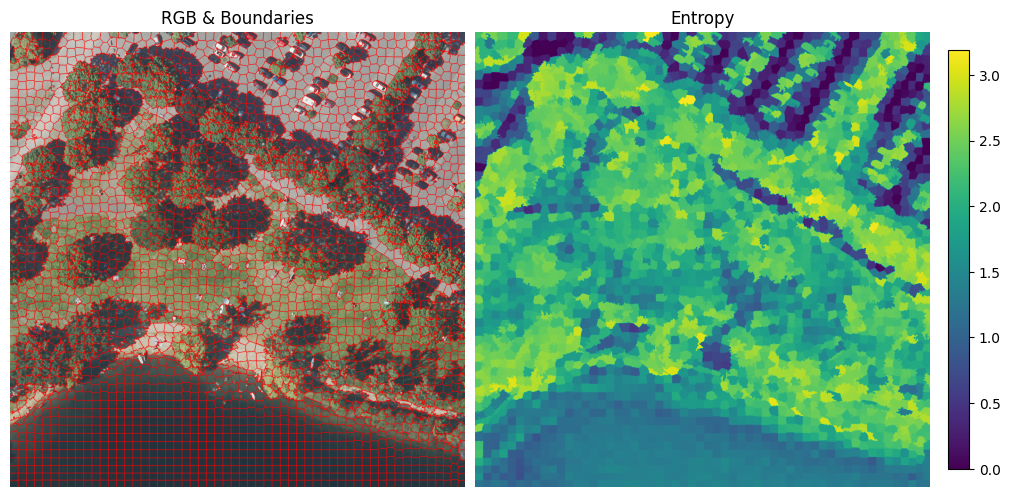

In [20]:
# Visualise results
mapped_entropy = map_array(segments, np.unique(segments), np.array(entropy["entropy_ndvi"]))

fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

im=axs[1].imshow(mapped_entropy)
axs[1].set_title("Entropy")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

for ax in axs.flat:
    ax.set_axis_off();

### **IV. Size features**

In addition to spectral, textural, and shape properties, each segment can also be characterized by its **size**. Size  features describe the dimensions and scale of objects and help distinguish small objects (like cars) from medium and large objects (like vegetation patches and water bodies).

I extend the notebook functionality by using the following two size measures:
1.  **Area**-number of pixels within a segment
2.   **Perimeter**-length of the segment boundary, describing boundary extent.

#### **I. Area**

Area represents the number of pixels contained within each segmented object and provides a direct measure of object size. It is computed from the segmentation result by counting the pixels belonging to each segment and is used to describe the relative size of objects in the image.





In [22]:
#define area calculation function
@timeit #the time function
def calc_area(seg_arr):
    area_feats = regionprops_table(
        label_image = seg_arr, #the segmented image
        properties = ["label", "area"]  #calculate each segment area
    )
    return pd.DataFrame(area_feats)  #return the output as a dataframe

#perform calculation
area = calc_area(segments)
display(area)

Execution time: 0.51s


label   area
0         1  513.0
1         2  464.0
2         3  628.0
3         4  884.0
4         5  906.0
...     ...    ...
2952   2953  621.0
2953   2954  621.0
2954   2955  596.0
2955   2956  541.0
2956   2957  494.0

[2957 rows x 2 columns]

In [24]:
#area descriptive stats
print("Min Area :", area['area'].min())
print("Max Area:", area['area'].max())

Min Area : 361.0
Max Area: 2290.0


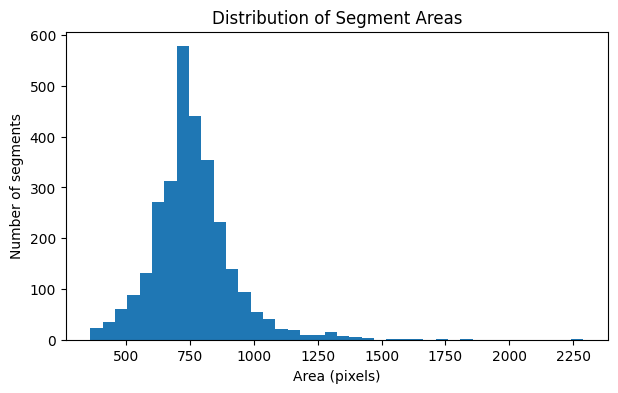

In [25]:
#plot segments distribution by area
plt.figure(figsize=(7,4))
plt.hist(area["area"], bins=40)
plt.title("Distribution of Segment Areas")
plt.xlabel("Area (pixels)")
plt.ylabel("Number of segments")
plt.show()

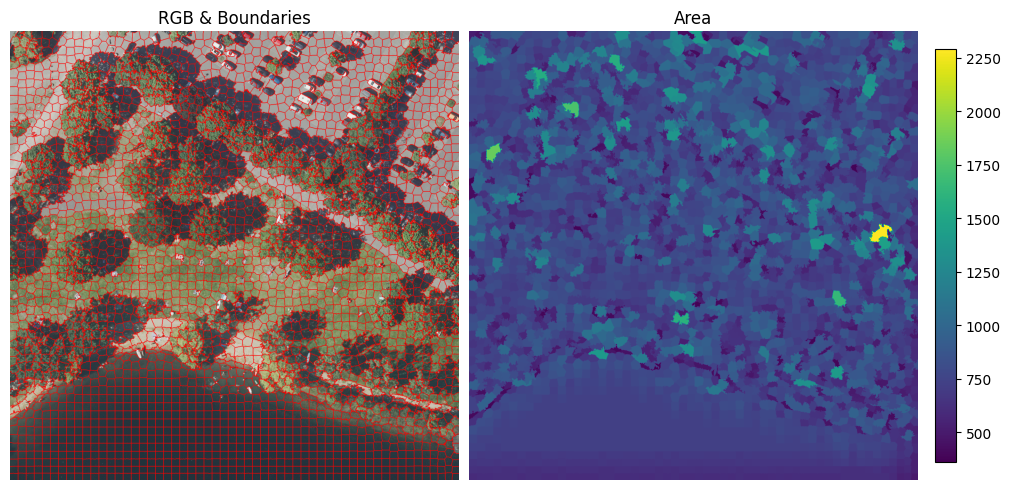

In [27]:
# Map area values back to pixel grid
mapped_area = map_array(
    segments,
    area["label"].to_numpy(),
    area["area"].to_numpy()
)

# Visualize
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

im = axs[1].imshow(mapped_area)
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Area per Segment")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()

Earlier, mean intensity values were computed using a stacked image consisting of the RGB bands and NDVI. When a multi-band image is provided to the feature extraction function, a separate mean value is produced for each band. These are returned as `intensity_mean-0`, `intensity_mean-1`, `intensity_mean-2`, and `intensity_mean-3`, corresponding to Red, Green, Blue, and NDVI respectively. In the following section of the code, the NDVI mean (`intensity_mean-3`) is reused and combined with size features.


In [30]:
#extract the mean ndvi from the means table
means_ndvi=means["intensity_mean-3"].rename("ndvi_mean")
means_ndvi

0       0.039661
1       0.288713
2       0.253889
3       0.421836
4       0.406761
          ...   
2952    0.222641
2953    0.224049
2954    0.217008
2955    0.215110
2956    0.207404
Name: ndvi_mean, Length: 2957, dtype: float64

In [31]:
#combining mean_ndvi and area to one table
seg_area_ndvi=area.join(means_ndvi)
seg_area_ndvi

label   area  ndvi_mean
0         1  513.0   0.039661
1         2  464.0   0.288713
2         3  628.0   0.253889
3         4  884.0   0.421836
4         5  906.0   0.406761
...     ...    ...        ...
2952   2953  621.0   0.222641
2953   2954  621.0   0.224049
2954   2955  596.0   0.217008
2955   2956  541.0   0.215110
2956   2957  494.0   0.207404

[2957 rows x 3 columns]

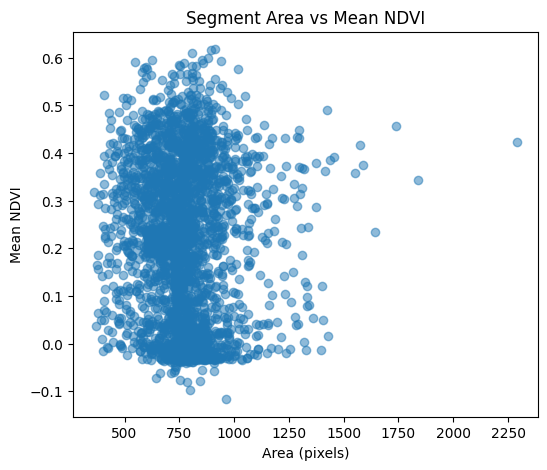

In [32]:
# Scatter plot: Area vs Mean NDVI
plt.figure(figsize=(6,5))
plt.scatter(seg_stats["area"], seg_stats["mean_ndvi"], alpha=0.5)
plt.title("Segment Area vs Mean NDVI")
plt.xlabel("Area (pixels)")
plt.ylabel("Mean NDVI")
plt.show()

## **Conclusion & Further thoughts**

This tutorial has demonstrated how to calculate and visualize a variety of features, each offering different insights into the segmented regions of an image. The choice of features depends on the segmentation technique used and the specific application at hand. Key considerations when selecting features include:

*   **Interpretability of features** - Some features, like compactness, offer intuitive insights, while others may require more in-depth understanding to interpret correctly.
*   **Scalability of calculations** - As datasets grow larger, especially in the context of big data, it becomes increasingly important to choose descriptors that are computationally efficient.